Setup

In [1]:
import os
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib
#from matplotlib.backends.backend_pdf import PdfPages
#import seaborn as sns
#import statsmodels.api as sm

#lowess = sm.nonparametric.lowess
from tqdm import tqdm
import sys

sys.path.append('/private/groups/shapirolab/brock/Software')
from py3_functions import *

from IPython.display import display

!mkdir -p /private/groups/shapirolab/brock/mutation
os.chdir('/private/groups/shapirolab/brock/mutation')
!mkdir -p cmds logs

### R stuff
from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

samples = []
with open('poplists/samples.txt') as infile:
    for line in infile:
        line = line.strip()
        samples.append(line)
infile.close()

wild = {}

!mkdir -p wild
with open('poplists/wild_caught_SRA.txt','r') as infile:
    for line in infile:
        line = line.strip()
        SRR, name = line.split('\t')
        wild[name] = SRR
infile.close()

In [4]:
%%R
library(tidyverse)
library(data.table)
library(ggplot2)
library(magrittr)

## Wild pop. polymorphism

### Variant calling

Download SRA data

In [9]:
for SAMPLE, SRR in wild.items():
    cmd = f"fasterq-dump {SRR} -O wild/"
    slurm = make_slurm(echo = False, id = f"{SRR}",cmd_string = cmd, mem = '60000', time = '24:00:00', p = 'long')

FASTP

In [5]:
import glob
!mkdir -p wild/fastp/
for SAMPLE, SRR in wild.items():
    R1 = f"wild/{SRR}_1.fastq"
    R2 = f"wild/{SRR}_2.fastq"
    OUT1 = re.sub('wild/','wild/fastp/',R1) + '.gz'
    OUT2 = re.sub('wild/','wild/fastp/',R2) + '.gz'
    UP1 = re.sub('.fastq.gz','_unpaired.fastq.gz',OUT1)
    UP2 = re.sub('.fastq.gz','_unpaired.fastq.gz',OUT2)
    cmd = f"fastp -V --in1 {R1} --in2 {R2} --out1 {OUT1} --out2 {OUT2} --unpaired1 {UP1} --unpaired2 {UP2} "
    slurm = make_slurm(run = False, id = f"{SAMPLE}.fastp",cmd_string = cmd, mem = '25000',time='24:00:00',p = 'long')

Alignment

In [6]:
RAWDIR = 'wild/fastp/'
WORKDIR = 'wild/aln/'
!mkdir -p $WORKDIR
refgenome = 'white_abalone.fasta'
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/abalone/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'


for SAMP,SRR in wild.items():
    
    ## Alignment
    aln_1 = ('''if [[ ! -f {WORKDIR}/{SAMP}.bam.bai ]];then '''
            '''{s_lic} {s_temp}'''
           '''({s_exec} '''
           '''bwa mem -R \'@RG\\tID:{SAMP}\\tSM:{SAMP}\\tPL:ILLUMINA\' '''
           '''-aM -t 16 {refgenome} {RAWDIR}/{SRR}_1.fastq.gz {RAWDIR}/{SRR}_2.fastq.gz '''
           '''|| echo -n \'error\') | '''
           '''{s_exec} util sort -r {refgenome} -o {WORKDIR}/{SAMP}.bam --sam2bam -i -;fi \n\n\n\n''').format(SRR = SRR, RAWDIR = RAWDIR, s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, s_temp = s_temp, WORKDIR = WORKDIR, SAMP = SAMP)

    ## Duplicate marking
    dups_p1 = ('''{s_lic} {s_temp}'''
               '''{s_exec} '''
               '''driver -i {WORKDIR}/{SAMP}.bam --algo LocusCollector --fun score_info {WORKDIR}/{SAMP}_SCORE.gz\n'''
               '''\n\n\n''').format(s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, WORKDIR = WORKDIR, SAMP = SAMP, s_temp = s_temp)
    
    dups_p2 = ('''echo -e "Dups p1. completed\\n\\n";'''
               '''{s_exec} '''
               '''driver -i {WORKDIR}/{SAMP}.bam --algo Dedup --score_info {WORKDIR}/{SAMP}_SCORE.gz '''
               '''--metrics {WORKDIR}/{SAMP}.metrics.txt {WORKDIR}/{SAMP}.mdup.bam\n'''
               '''\n\n\n''').format(s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, WORKDIR = WORKDIR, s_temp = s_temp, SAMP = SAMP)
    
    ## Min Qual, RM DUP
    #proc_cmd = ('''samtools view -q 20 -b {WORKDIR}/{SAMP}.mdup.bam | '''
    #            '''samtools sort | '''
    #            '''samtools rmdup - {WORKDIR}/{SAMP}.qF.bam\n\n\n''').format(SAMP = SAMP, WORKDIR = WORKDIR)
    
    
    ## FLAGSTAT
    stat_cmd = ('''samtools flagstat {WORKDIR}/{SAMP}.mdup.bam > {WORKDIR}/{SAMP}.filt.stats.txt\n'''
                #'''samtools flagstat {WORKDIR}/{SAMP}.qF.bam > {WORKDIR}/{SAMP}.filt.qF.stats.txt\n\n\n'''
                '''''').format(WORKDIR = WORKDIR, SAMP = SAMP)
    
    full_cmd = aln_1 + dups_p1 + dups_p2 + stat_cmd
    slurm = make_slurm(run = False, id = f"{SAMP}.aln", cmd_string = full_cmd, mem = '120000', time = '48:00:00', p = 'long',c=16)

Haplotype caller

In [7]:
### PATHS ###
refgenome = 'white_abalone.fasta'
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/abalone/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'

!mkdir -p wild/gvcfs
### GENERATE CMDS ###
#for sample, data in complete.items():
for sample in wild.keys():
    bam = f"wild/aln/{sample}.mdup.bam"
    if not os.path.exists(bam + ".bai"): continue
    ##
    haplo_cmd = ('''{s_lic} {s_temp}'''
                 '''{s_exec} '''
                 '''driver -t 32 -r {refgenome} -i {bam} '''
                 '''--algo Haplotyper --emit_mode gvcf '''
                 '''wild/gvcfs/{sample}.gvcf.gz\n''').format(bam = bam, sample = sample, refgenome = refgenome, s_lic = s_lic, s_temp = s_temp, s_exec = s_exec)
    make_slurm(run = False, id = f"{sample}.hapcal",cmd_string = haplo_cmd, mem = '100000',c = 32, p = 'long', time = '12:00:00')

Joint genotyping, emit all variants

In [13]:
### PATHS ###
brockdir = "/private/groups/shapirolab/brock"
refgenome = 'white_abalone.fasta'
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/abalone/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'

chroms = []
with open('white_abalone.fasta.fai','r') as infile:
    for line in infile:
        line = line.strip()
        parts = line.split('\t')
        chrom, size = parts[0:2]
        if int(size) < 1e6: 
            continue
        else:
            chroms.append(chrom)
gvcf_string = ''
infile = open('poplists/wild_caught_SRA.txt','r')
for line in infile:
    line = line.strip('\n')
    sample = line.split('\t')[1]
    gvcf_string += f"-v wild/gvcfs/{sample}.gvcf.gz "
infile.close()

!mkdir -p wild/vcfs
for CHROM in chroms:
    joint_cmd = ('''{s_lic} {s_temp}'''
                 '''{s_exec} '''
                 '''driver -t 8 -r {refgenome} --interval {CHROM} --algo GVCFtyper '''
                 '''{gvcf_string} '''
                 '''--emit_mode ALL '''
                 '''wild/vcfs/{CHROM}.allsites.vcf.gz\n''').format(CHROM = CHROM, s_temp = s_temp, s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, gvcf_string = gvcf_string)
    slurm = make_slurm(run = False, id = f"{CHROM}.joint",p = 'long', cmd_string =  joint_cmd, mem = '40000',time='04:00:00', c=8)

Filtering

In [14]:
WORKDIR = '/private/groups/shapirolab/brock/mutation/'
GATK = '/private/groups/shapirolab/brock/Software/gatk.sif'

for CHROM in chroms:
    cmd = (
        ## Basic INvariant site selection and filtering
        '''bcftools view --max-ac 0:minor -i "QUAL>30 && F_MISSING<0.25" -O z '''
        '''wild/vcfs/{CHROM}.allsites.vcf.gz > wild/vcfs/{CHROM}.NON.vcf.gz && tabix -f wild/vcfs/{CHROM}.NON.vcf.gz\n\n'''
        
        ## Basic VARIANT site selection and filtering
        '''bcftools view --min-ac 1:minor -i "QUAL>30 && F_MISSING<0.25" -O z '''
        '''wild/vcfs/{CHROM}.allsites.vcf.gz > wild/vcfs/{CHROM}.VAR.vcf.gz && tabix -f wild/vcfs/{CHROM}.VAR.vcf.gz\n\n'''
       
        ## Apply more thorough GATK filters to VARIANT set
        '''singularity exec --bind {WORKDIR} {GATK} '''
        '''gatk --java-options "-Xmx4G" VariantFiltration '''
        '''-R white_abalone.fasta '''
        '''-V wild/vcfs/{CHROM}.VAR.vcf.gz '''
        '''--output wild/vcfs/{CHROM}.VARFILTERED.vcf.gz '''
        '''--filter-name \"RPRS_filter\" --filter-expression \"(vc.isSNP() && (vc.hasAttribute('ReadPosRankSum') && ReadPosRankSum < -8.0)) || ((vc.isIndel() || vc.isMixed()) && (vc.hasAttribute('ReadPosRankSum') && ReadPosRankSum < -20.0)) || (vc.hasAttribute('QD') && QD < 2.0)\" '''
        '''--filter-name \"FS_SOR_filter\" --filter-expression \"(vc.isSNP() && ((vc.hasAttribute('FS') && FS > 60.0) || (vc.hasAttribute('SOR') &&  SOR > 3.0))) || ((vc.isIndel() || vc.isMixed()) && ((vc.hasAttribute('FS') && FS > 200.0) || (vc.hasAttribute('SOR') &&  SOR > 10.0)))\" '''
        '''--filter-name \"MQ_filter\" --filter-expression \"vc.isSNP() && ((vc.hasAttribute('MQ') && MQ < 40.0) || (vc.hasAttribute('MQRankSum') && MQRankSum < -12.5))\" '''
        '''--filter-name \"QUAL_filter\" --filter-expression \"QUAL < 30.0\" '''
        '''--invalidate-previous-filters true && tabix -f wild/vcfs/{CHROM}.VARFILTERED.vcf.gz\n\n'''
        
        ## Recombine filtered INVAR + VARIANT vcfs, remove intermediate files
        '''bcftools concat --allow-overlaps wild/vcfs/{CHROM}.VARFILTERED.vcf.gz wild/vcfs/{CHROM}.NON.vcf.gz '''
        '''-O z > wild/vcfs/{CHROM}.allsites.filtered.vcf.gz && tabix -f wild/vcfs/{CHROM}.allsites.filtered.vcf.gz\n\n'''
        '''if [[ -f wild/vcfs/{CHROM}.allsites.filtered.vcf.gz.tbi ]];then rm -f wild/vcfs/{CHROM}.VARFILTERED.vcf.gz* wild/vcfs/{CHROM}.VAR.vcf.gz* wild/vcfs/{CHROM}.NON.vcf.gz*;fi\n''').format(CHROM = CHROM, WORKDIR = WORKDIR, GATK = GATK)
    
    slurm = make_slurm(run = False, id = f"{CHROM}.filter", cmd_string = cmd, mem='5000',time='48:00:00',p='long')

### PIXY

For white abalone

In [102]:
!mkdir -p wild/pixy
for chrom in chroms:
    pixy_cmd = ('''pixy --stats pi '''
                '''--vcf wild/vcfs/{chrom}.allsites.filtered.vcf.gz '''
                '''--populations poplists/wild_pop.txt '''
                '''--window_size 10000 '''
                '''--n_cores 8 '''
                '''--chromosomes {chrom} '''
                '''--output_folder wild/pixy --output_prefix {chrom}\n''').format(chrom = chrom)
    slurm = make_slurm(run = False, c = 8, p = 'long', id=f"{chrom}.pixy", cmd_string = pixy_cmd, mem='20000', time = '24:00:00')
    

For black abalone as well. I'm pulling these vcfs directly from my previous work (Wooldridge et al. 2024).

In [171]:
fai = pd.read_csv('assembly/cracherodii.fa.fai', sep="\t", header = None).set_axis(['chrom', 'size', 'cum', 'a', 'b'], axis=1).query('size > 1e6')
chroms = list(fai['chrom'])
for chrom in chroms:
    pixy_cmd = ('''pixy --stats pi '''
                '''--vcf /private/groups/shapirolab/brock/abalone/vcfs/{chrom}.allsites.hf.vcf.gz '''
                '''--populations poplists/black_ab_sample.txt '''
                '''--window_size 10000 '''
                '''--n_cores 16 '''
                '''--chromosomes {chrom} '''
                '''--output_folder wild/black_ab/pixy --output_prefix {chrom}\n''').format(chrom = chrom)
    slurm = make_slurm(run = False, c = 16, p = 'long', id=f"black.ab.{chrom}.pixy", cmd_string = pixy_cmd, mem='20000', time = '24:00:00')
    

Results

In [176]:
%%R
white_pi = bind_rows(lapply(list.files('wild/pixy',pattern = 'scaffold', full.names = T),function(PATH){fread(PATH)}))
black_pi = bind_rows(lapply(list.files('wild/black_ab/pixy/',pattern = 'pi', full.names = T),function(PATH){fread(PATH)}))
pi = bind_rows(white_pi %>% mutate(species = 'white'), black_pi %>% mutate(species = 'black'))
head(pi)

      pop     chromosome window_pos_1 window_pos_2       avg_pi no_sites
   <char>         <char>        <int>        <int>        <num>    <int>
1:  dummy HiC_scaffold_1            1        10000 0.0001431941     5083
2:  dummy HiC_scaffold_1        10001        20000 0.0001239201     2500
3:  dummy HiC_scaffold_1        20001        30000 0.0131363609     1436
4:  dummy HiC_scaffold_1        30001        40000 0.0037452543     8173
5:  dummy HiC_scaffold_1        40001        50000 0.0004181712     8317
6:  dummy HiC_scaffold_1        50001        60000 0.0011203337     7564
   count_diffs count_comparisons count_missing species
         <int>             <int>         <int>  <char>
1:         154           1075463         98710   white
2:          64            516462         61038   white
3:        3901            296962         34754   white
4:        6566           1753152        134811   white
5:         753           1800698        120529   white
6:        1837           163969

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


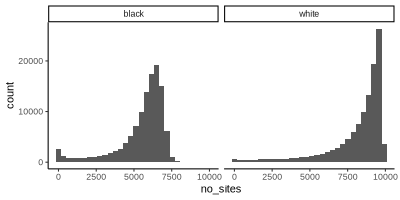

In [177]:
%%R -w 400 -h 200
ggplot(pi) +
    geom_histogram(aes(x = no_sites)) +
    facet_wrap(~species) +
    theme_classic()

Plot result

In [197]:
%%R -w 700 -h 350
library(patchwork)

inpi = pi %>% filter(species == 'white', no_sites > 9000)
p = ggplot(inpi) +
    geom_histogram(aes(x = avg_pi)) +
    geom_vline(aes(xintercept = mean(avg_pi)), col = 'red') +  
    #geom_vline(aes(xintercept = median(avg_pi)), col = 'blue') + 
    annotate("text",x=0.01, y = 10000,label = paste0("Median ",round(median(inpi$avg_pi),4)), col = 'blue') +
    annotate("text",x=0.01, y = 12000,label = paste0("Mean ",round(mean(inpi$avg_pi),4)), col = 'red') +
    theme_classic() +
    xlim(c(0,0.05)) +
    ylab("Count") +
    xlab("Avg. pi (10kb window)")


inpi = pi %>% filter(species == 'black', no_sites > 6000)
q = ggplot(inpi) +
    geom_histogram(aes(x = avg_pi)) +
    geom_vline(aes(xintercept = mean(avg_pi)), col = 'red') +  
    #geom_vline(aes(xintercept = median(avg_pi)), col = 'blue') + 
    annotate("text",x=0.03, y = 8000,label = paste0("Median ",round(median(inpi$avg_pi),4)), col = 'blue') +
    annotate("text",x=0.03, y = 10000,label = paste0("Mean ",round(mean(inpi$avg_pi),4)), col = 'red') +
    theme_classic() + 
    xlim(c(0,0.05)) +
    ylab("Count") +
    xlab("Avg. pi (10kb window)")


p/q
ggsave('mutation_figs/pi.pdf',height = 4, width = 4)
#ggsave('mutation_figs/pi.pdf',height = 3.5, width = 7)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


### Other species

In [72]:
%%R
library(readxl)
mut = read_excel('mutation_literature/mutation_rate_literature_updating3.xlsx', sheet = 1)
mut %<>% bind_rows(.,data.frame(Species = "Haliotis sorenseni",u_mean = '7.99e-09', u_lower = '6.096043e-09', u_upper = '1.111221e-08', TYPE = 'snp',reproduction = 'sexual',Group = 'mollusks', Broadcast = 'Y'))
diversity = read_excel('mutation_literature/mutation_rate_literature_updating3.xlsx', sheet = 2)
diversity %<>% bind_rows(.,data.frame(Species = "Haliotis sorenseni",Gs_MB = 1184.464861, Gt_Year = 10, log10_popsize = NA, diversity = 0.001768821))

In [106]:
%%R -w 500 -h 350
library(wesanderson)
library(scico)
inp = 
    left_join(mut,diversity, by = 'Species') %>% 
    mutate(u_mean = as.numeric(u_mean)) %>%
    filter(TYPE == 'snp') %>%
    filter(reproduction == 'sexual') %>%
    filter(!Group %in% c('human','unicellular'))
p = ggplot() +
    geom_point(data = inp %>% filter(diversity != 0), aes(x = u_mean, y = diversity, fill = Broadcast), size = 4, pch = 21) +
    scale_fill_manual(values = wes_palette("AsteroidCity2")[c(6,5)]) +
    ylab("Diversity") +
    xlab("Mutation rate") + 
    scale_x_log10(guide = "axis_logticks") + 
    scale_y_log10(guide = "axis_logticks") +
    #scale_fill_scico_d(palette = 'vik') +
    #geom_point(data = inp %>% filter(Species == 'Haliotis sorenseni'), aes(x = log(u_mean), y = log(diversity)), col = 'red', size = 2) +
    #geom_abline(aes(slope = log(e))) +
    theme_classic()
pdf('mutation_figs/pi_v_mut.pdf',width  = 5, height = 3.5)
print(p)
dev.off()


png 
  2 


## MSMC multiple species

### Download other Haliotis

In [30]:
%%R -o dl
raw = fread('demography/haliotis_wgs_2024.csv') 
keep = 
    raw %>%
    dplyr::select(Organism,Run, Bases, BioSample, `Sample Name`, `Library Name`) %>%
    group_by(Organism,BioSample) %>%
    summarize(TotalBases = sum(Bases)) %>%
    ungroup %>%
    group_by(Organism) %>%
    filter(TotalBases == max(TotalBases)) %>%
    filter(!Organism %in% c('Haliotis sorenseni')) %>%
    pull(BioSample)

dl =
    raw %>% 
    filter(BioSample %in% keep) %>%
    dplyr::select(Organism,Run)

fwrite(dl, 'demography/download.txt', sep = "\t", col.names = F, row.names = F)

`summarise()` has grouped output by 'Organism'. You can override using the
`.groups` argument.


In [16]:
org_2_run = {}
with open('demography/download.txt','r') as infile:
    for line in infile:
        Organism, Run = line.strip('\n').split('\t')
        Organism = re.sub('Haliotis ','',Organism)
        if Organism not in org_2_run.keys():
            org_2_run[Organism] = [Run]
        else:
            org_2_run[Organism].append(Run)
infile.close()

for SPECIES, SRRlist in org_2_run.items():
    if SPECIES != 'asinina': continue
    for SRR in SRRlist:
        cmd = f"fasterq-dump {SRR} -O demography/"
        slurm = make_slurm(run = False, id = f"{SRR}",cmd_string = cmd, mem = '60000', time = '24:00:00', p = 'long')

### Fastp

In [17]:
import glob
!mkdir -p demography/fastp/

org_2_run = {}
with open('demography/download.txt','r') as infile:
    for line in infile:
        Organism, Run = line.strip('\n').split('\t')
        Organism = re.sub('Haliotis ','',Organism)
        if Organism not in org_2_run.keys():
            org_2_run[Organism] = [Run]
        else:
            org_2_run[Organism].append(Run)
infile.close()


for SPECIES, SRRlist in org_2_run.items():
    if SPECIES != 'asinina': continue
    for SRR in SRRlist:
        R1 = f"demography/{SRR}_1.fastq"
        R2 = f"demography/{SRR}_2.fastq"
        OUT1 = re.sub('demography/','demography/fastp/',R1) + '.gz'
        OUT2 = re.sub('demography/','demography/fastp/',R2) + '.gz'
        UP1 = re.sub('.fastq.gz','_unpaired.fastq.gz',OUT1)
        UP2 = re.sub('.fastq.gz','_unpaired.fastq.gz',OUT2)
        cmd = f"fastp -V --in1 {R1} --in2 {R2} --out1 {OUT1} --out2 {OUT2} --unpaired1 {UP1} --unpaired2 {UP2} "
        slurm = make_slurm(run = False, id = f"{SRR}.fastp",cmd_string = cmd, mem = '25000',time='24:00:00',p = 'long')

### Alignment

In [18]:
RAWDIR = 'demography/fastp/'
WORKDIR = 'demography/aln/'
!mkdir -p $WORKDIR
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/mutation/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'

org_2_run = {}
with open('demography/download.txt','r') as infile:
    for line in infile:
        Organism, Run = line.strip('\n').split('\t')
        Organism = re.sub('Haliotis ','',Organism)
        if Organism not in org_2_run.keys():
            org_2_run[Organism] = [Run]
        else:
            org_2_run[Organism].append(Run)
infile.close()


for SPECIES, SRRlist in org_2_run.items():
    if SPECIES not in ['asinina']: continue
    refgenome = f"assembly/{SPECIES}.fa"
    for SRR in SRRlist:
        if os.path.exists(f"{WORKDIR}/{SRR}.mdup.bam"):
            print(f"{SRR} done")
            continue
        else:
            print(f"{SRR} incomplete")
        ## Alignment
        aln_1 = ('''if [[ ! -f {WORKDIR}/{SRR}.bam.bai ]];then '''
                '''{s_lic} {s_temp}'''
               '''({s_exec} '''
               '''bwa mem -R \'@RG\\tID:{SRR}\\tSM:{SPECIES}\\tPL:ILLUMINA\' '''
               '''-aM -t 16 {refgenome} {RAWDIR}/{SRR}_1.fastq.gz {RAWDIR}/{SRR}_2.fastq.gz '''
               '''|| echo -n \'error\') | '''
               '''{s_exec} util sort -r {refgenome} -o {WORKDIR}/{SRR}.bam --sam2bam -i -;fi \n\n\n\n''').format(SRR = SRR, RAWDIR = RAWDIR, s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, s_temp = s_temp, WORKDIR = WORKDIR, SPECIES = SPECIES)
    
        ## Duplicate marking
        dups_p1 = ('''{s_lic} {s_temp}'''
                   '''{s_exec} '''
                   '''driver -i {WORKDIR}/{SRR}.bam -t 16 --algo LocusCollector --fun score_info {WORKDIR}/{SRR}_SCORE.gz\n'''
                   '''\n\n\n''').format(s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, WORKDIR = WORKDIR, SRR = SRR, s_temp = s_temp)
        
        dups_p2 = ('''echo -e "Dups p1. completed\\n\\n";'''
                   '''{s_exec} '''
                   '''driver -i {WORKDIR}/{SRR}.bam -t 16 --algo Dedup --score_info {WORKDIR}/{SRR}_SCORE.gz '''
                   '''--metrics {WORKDIR}/{SRR}.metrics.txt {WORKDIR}/{SRR}.mdup.bam\n'''
                   '''\n\n\n''').format(s_lic = s_lic, s_exec = s_exec, refgenome = refgenome, WORKDIR = WORKDIR, s_temp = s_temp, SRR = SRR)
        
        ## Min Qual, RM DUP
        #proc_cmd = ('''samtools view -q 20 -b {WORKDIR}/{SAMP}.mdup.bam | '''
        #            '''samtools sort | '''
        #            '''samtools rmdup - {WORKDIR}/{SAMP}.qF.bam\n\n\n''').format(SAMP = SAMP, WORKDIR = WORKDIR)
        
        
        ## FLAGSTAT
        stat_cmd = ('''samtools flagstat {WORKDIR}/{SRR}.mdup.bam > {WORKDIR}/{SRR}.filt.stats.txt\n'''
                    #'''samtools flagstat {WORKDIR}/{SAMP}.qF.bam > {WORKDIR}/{SAMP}.filt.qF.stats.txt\n\n\n'''
                    '''''').format(WORKDIR = WORKDIR, SRR = SRR)
        
        full_cmd = aln_1 + dups_p1 + dups_p2 + stat_cmd
        slurm = make_slurm(run = False, id = f"{SRR}.aln", cmd_string = full_cmd, mem = '120000', time = '72:00:00', p = 'long',c=16)

SRR24969063 incomplete


Merge. Once merging is done, remove original per-run files

In [21]:
outfile = open('cmds/merge.txt','w')
WORKDIR = "demography/aln/"
for SPECIES, SRRlist in org_2_run.items():
    cmd = ""
    if len(SRRlist) > 1:
        cmd = f"samtools merge -f -@ 16 -O BAM -o {WORKDIR}/{SPECIES}.bam "
        for SRR in SRRlist:
            #if not os.path.exists(f"{WORKDIR}/{SRR}.mdup.bam"):
                #print(f"Issue with {SRR}")
            cmd += f"{WORKDIR}/{SRR}.mdup.bam "
        cmd += f"&& samtools index {WORKDIR}/{SPECIES}.bam"
    else:
        SRR = SRRlist[0]
        cmd = f"mv {WORKDIR}/{SRR}.mdup.bam {WORKDIR}/{SPECIES}.mdup.bam "
    outfile.write(cmd + "\n")
outfile.close()

### Variant calling

Haplotype caller

In [22]:
### PATHS ###
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/mutation/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'

!mkdir -p demography/gvcfs
### GENERATE CMDS ###
#for sample, data in complete.items():
#for SPECIES in org_2_run.keys():
for SPECIES in ['cracherodii']:
    bam = f"demography/aln/{SPECIES}.bam"
    if not os.path.exists(bam + ".bai"): 
        print(f"Error with {SPECIES}")
        continue
    ##
    haplo_cmd = ('''{s_lic} {s_temp}'''
                 '''{s_exec} '''
                 '''driver -t 32 -r assembly/{SPECIES}.fa -i {bam} '''
                 '''--algo Haplotyper --emit_mode gvcf '''
                 '''demography/gvcfs/{SPECIES}.gvcf.gz\n''').format(bam = bam, SPECIES = SPECIES, refgenome = refgenome, s_lic = s_lic, s_temp = s_temp, s_exec = s_exec)
    make_slurm(echo = False, run = False, id = f"{SPECIES}.hapcal",cmd_string = haplo_cmd, mem = '100000',c = 32, p = 'long', time = '12:00:00')

Error with cracherodii


Joint genotyping, only emit variant sites

In [23]:
### PATHS ###
brockdir = "/private/groups/shapirolab/brock"
s_lic = 'export SENTIEON_LICENSE=/private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon licsrvr --start --log /private/groups/shapirolab/brock/abalone/sentieon.log --linger 300 /private/groups/shapirolab/Software/Licenses/UCSC_Paleogenomics_Lab_Beth_Shapiro_cluster.lic;'
s_temp = "export SENTIEON_TMPDIR=/private/groups/shapirolab/brock/abalone/tmp/;"
s_exec = '/private/groups/shapirolab/Software/Tools/sentieon-genomics-202308/bin/sentieon'



!mkdir -p demography/vcfs
for SPECIES in org_2_run.keys():
    #chroms = pd.read_csv(f"assembly/{SPECIES}.fa.fai", sep = "\t", header = None).set_axis(['chr','size','total','l','n'], axis = 1).query('size > 5e5')['chr'].to_list()
    #for CHROM in chroms:
    joint_cmd = ('''{s_lic} {s_temp}'''
                 '''{s_exec} '''
                 '''driver -t 8 -r assembly/{SPECIES}.fa --algo GVCFtyper ''' # --interval {CHROM}
                 '''-v demography/gvcfs/{SPECIES}.gvcf.gz '''
                 '''demography/vcfs/{SPECIES}.vcf.gz\n''').format(SPECIES = SPECIES, s_temp = s_temp, s_lic = s_lic, s_exec = s_exec)
    slurm = make_slurm(run = False, id = f"{SPECIES}.joint",p = 'long', cmd_string =  joint_cmd, mem = '40000',time='04:00:00', c=8)

Filter 

In [24]:
WORKDIR = '/private/groups/shapirolab/brock/mutation/'
GATK = '/private/groups/shapirolab/brock/Software/gatk.sif'

for SPECIES in org_2_run.keys():
    cmd = (
        ## Apply more thorough GATK filters to VARIANT set
        '''singularity exec --bind {WORKDIR} {GATK} '''
        '''gatk --java-options "-Xmx4G" VariantFiltration '''
        '''-R assembly/{SPECIES}.fa '''
        '''-V demography/vcfs/{SPECIES}.vcf.gz '''
        '''--output demography/vcfs/{SPECIES}.filtered.vcf.gz '''
        '''--filter-name \"RPRS_filter\" --filter-expression \"(vc.isSNP() && (vc.hasAttribute('ReadPosRankSum') && ReadPosRankSum < -8.0)) || ((vc.isIndel() || vc.isMixed()) && (vc.hasAttribute('ReadPosRankSum') && ReadPosRankSum < -20.0)) || (vc.hasAttribute('QD') && QD < 2.0)\" '''
        '''--filter-name \"FS_SOR_filter\" --filter-expression \"(vc.isSNP() && ((vc.hasAttribute('FS') && FS > 60.0) || (vc.hasAttribute('SOR') &&  SOR > 3.0))) || ((vc.isIndel() || vc.isMixed()) && ((vc.hasAttribute('FS') && FS > 200.0) || (vc.hasAttribute('SOR') &&  SOR > 10.0)))\" '''
        '''--filter-name \"MQ_filter\" --filter-expression \"vc.isSNP() && ((vc.hasAttribute('MQ') && MQ < 40.0) || (vc.hasAttribute('MQRankSum') && MQRankSum < -12.5))\" '''
        '''--filter-name \"QUAL_filter\" --filter-expression \"QUAL < 30.0\" '''
        '''--invalidate-previous-filters true && tabix -f demography/vcfs/{SPECIES}.filtered.vcf.gz\n\n''').format(SPECIES = SPECIES, WORKDIR = WORKDIR, GATK = GATK)
    
    slurm = make_slurm(echo = False, run = False, id = f"{SPECIES}.filter", cmd_string = cmd, mem='5000',time='48:00:00',p='long')

### MSMC input

#### Mappability masks reference genomes

In [35]:
!mkdir -p demography/mappability
species = []
with open('poplists/phylo_species.txt','r') as infile:
    for line in infile:
        line = line.strip()
        if line != 'magus': species.append(line)
infile.close()

for SPECIES in species:
    cmd = ('''genmap index -F assembly/{SPECIES}.fa -I demography/mappability/{SPECIES} -v''').format(SPECIES = SPECIES) 
    !$cmd

Input fits into int32_t (<2GB), algorithm will need about `6n` main memory.
It might be more or less depending on the number and length of the individual sequences.
If you are running out of memory, you can try to reduce the memory consumption a bit by inreasing `-S`, e.g., use `-S 20` (up to 64).
Although this will slow down the algorithm to compute the mappability.
Index will be constructed using dna5/rna5 alphabet.
- The BWT is represented by 32 bit values.
- The sampled suffix array is represented by pairs of 16 and 32 bit values.
Create fwd Index ... done!
Create bwd Index ... done!
Index created successfully.
Input fits into int32_t (<2GB), algorithm will need about `6n` main memory.
It might be more or less depending on the number and length of the individual sequences.
If you are running out of memory, you can try to reduce the memory consumption a bit by inreasing `-S`, e.g., use `-S 20` (up to 64).
Although this will slow down the algorithm to compute the mappability.
Index w

Now that the indexing is done, run the actual masking

In [9]:
!mkdir -p demography/mappability
species = []
with open('poplists/phylo_species.txt','r') as infile:
    for line in infile:
        line = line.strip()
        if line != 'magus': species.append(line)
infile.close()

for SPECIES in species:
    cmd = ('''genmap map -K 150 -E 2 -I demography/mappability/{SPECIES} -O demography/mappability/{SPECIES}/150_by_2 -bg ''').format(SPECIES = SPECIES)
    slurm = make_slurm(run = False, id = f"{SPECIES}.genmap", cmd_string = cmd, mem = '40000', time = '48:00:00', p = 'long')

Reformat as a negative bed mask

In [68]:
%%bash
find "demography" -name "150_by_2.bedgraph" | while read FILE;do
    echo $FILE
    OUTNAME=$(echo $FILE | sed "s|.bedgraph|_negative_mask.bed|")
    awk '{OFS="\t"} ($4 != 1) {print $1,$2,$3}' $FILE | bedtools merge -i stdin > $OUTNAME
done

demography/mappability/cracherodii/150_by_2.bedgraph
demography/mappability/asinina/150_by_2.bedgraph
demography/mappability/sorenseni/150_by_2.bedgraph
demography/mappability/rufescens/150_by_2.bedgraph
demography/mappability/rubra/150_by_2.bedgraph
demography/mappability/laevigata/150_by_2.bedgraph


#### Input data masking

Generate input depth masks<br>
This needs to be run per-chromosome, then combine later

First, get avg. depth per species

In [81]:
%%bash
cat demography/dem_species.txt | while read SPECIES;do
    large_chrom=$(sort -nrk2 assembly/${SPECIES}.fa.fai | head -n 1 | cut -f1);
    DEPTH=$(samtools depth -a -r ${large_chrom} demography/aln/${SPECIES}.bam | mdepth.sh | sed "s/Average =  //g");
    echo -e "$SPECIES\t$DEPTH";
done > demography/depth.txt

[W::hts_idx_load3] The index file is older than the data file: demography/aln/cracherodii.bam.bai


In [25]:
!mkdir -p demography/msmc demography/msmc/masks demography/msmc/vcfs

sample_cov = {}
with open('demography/depth.txt','r') as infile:
    next(infile) # skip header
    for line in infile:
        line = line.strip('\n')
        sample, mean = line.split('\t')
        sample_cov[sample] = mean
infile.close()

ix = 0
for SPECIES, COV in sample_cov.items():
    if float(COV) < 40: continue
    fai = pd.read_csv(f"assembly/{SPECIES}.fa.fai", sep="\t", header = None)
    chroms = fai[fai.iloc[:,1] > 5e5].iloc[:,0].tolist()
    outfile = open(f"cmds/{SPECIES}_msmc_mask.txt",'w')
    cmd = ""
    for chrom in chroms:
        ix += 1
        cmd += ('''samtools mpileup -q 20 -Q 20 -C 50 -u -r {chrom} -f assembly/{SPECIES}.fa demography/aln/{SPECIES}.bam | '''
               '''bcftools call -c -V indels --ploidy 2 | '''
               '''python /private/groups/shapirolab/brock/Software/msmc-tools/bamCaller.py {COV} demography/msmc/masks/{SPECIES}_{chrom}.bed.gz\n''').format(chrom = chrom, SPECIES = SPECIES, COV = COV)
    outfile.write(cmd)
    outfile.close()
    slurmcmd = f"cat cmds/{SPECIES}_msmc_mask.txt | parallel --progress --jobs 12"
    slurm = make_slurm(echo = False, p='long', id = f"{SPECIES}_msmc_mask", cmd_string = slurmcmd, mem = '10000', time = '24:00:00', c = 12)
print(ix)

1064


Generate sample-level vcfs

In [104]:
!mkdir -p demography/msmc/vcfs/
for SPECIES, COV in sample_cov.items():
    if float(COV) < 40: continue
    fai = pd.read_csv(f"assembly/{SPECIES}.fa.fai", sep="\t", header = None)
    chroms = fai[fai.iloc[:,1] > 5e5].iloc[:,0].tolist()
    outfile = open(f"cmds/{SPECIES}_msmc_vcf.txt",'w')
    cmd = ""
    for chrom in chroms:
        cmd += ('''bcftools view -r {chrom} --min-ac 1:minor -f PASS,. -v snps -m2 -M2 demography/vcfs/{SPECIES}.filtered.vcf.gz '''
               '''> demography/msmc/vcfs/{SPECIES}_{chrom}.vcf && bgzip -f demography/msmc/vcfs/{SPECIES}_{chrom}.vcf && tabix -f demography/msmc/vcfs/{SPECIES}_{chrom}.vcf.gz\n''').format(SPECIES = SPECIES, chrom = chrom)
    outfile.write(cmd)
    outfile.close()
    slurmcmd = f"cat cmds/{SPECIES}_msmc_vcf.txt | parallel --progress --jobs 12"
    slurm = make_slurm(echo = False, p='long', id = f"{SPECIES}_msmc_vcf", cmd_string = slurmcmd, mem = '10000', time = '24:00:00', c = 12)

Now add with mappability mask and vcf to generate input

In [26]:
import itertools
!mkdir -p demography/msmc/input


## Loop through species
for SPECIES, COV in sample_cov.items():
    if float(COV) < 40: continue
        
    ## Loop through chromosomes
    fai = pd.read_csv(f"assembly/{SPECIES}.fa.fai", sep="\t")
    chroms = fai[fai.iloc[:,1] > 5e5].iloc[:,0].tolist()
    outfile = open(f"cmds/{SPECIES}_msmc_input.txt",'w')
    cmd = ""
    for CHROM in chroms:
        cmd += ('''python /private/groups/shapirolab/brock/Software/msmc-tools/generate_multihetsep.py '''
                ## Positive mask
                '''--mask demography/msmc/masks/{SPECIES}_{CHROM}.bed.gz '''
                ## Negative mask
                '''--negative_mask demography/mappability/{SPECIES}/150_by_2_negative_mask.bed '''
                ## VCF
                '''demography/msmc/vcfs/{SPECIES}_{CHROM}.vcf.gz > '''
                ## Output
                '''demography/msmc/input/{SPECIES}_{CHROM}.multihetsep.TV.txt\n''').format(SPECIES = SPECIES, CHROM = CHROM)
    outfile.write(cmd)
    outfile.close()
    slurmcmd = f"parallel --progress --jobs 12 < cmds/{SPECIES}_msmc_input.txt"
    slurm = make_slurm(run = False, p='long', id = f"{SPECIES}_msmc_input", cmd_string = slurmcmd, mem = '10000', time = '24:00:00', c = 12)
    ## Done

#### Bootstrap replicates

In [132]:
!mkdir -p demography/msmc/bootstrap
sample_cov = {}
with open('demography/depth.txt','r') as infile:
    next(infile) # skip header
    for line in infile:
        line = line.strip('\n')
        sample, mean = line.split('\t')
        sample_cov[sample] = mean
infile.close()



outfile = open('cmds/genboot.txt','w')
for SPECIES, COV in sample_cov.items():
    if SPECIES == 'laevigata':
        size, chunks, chroms = 100000, 10, 1000 # fragmented aassembly
    else:
        size, chunks, chroms = 5000000, 10, 20
        
    cmd = ('''python /private/groups/shapirolab/brock/Software/msmc-tools/multihetsep_bootstrap.py '''
           '''-n 20 -s {size} --chunks_per_chromosome {chunks} --nr_chromosomes {chroms} ''' # Generates a resampled chromosome approximately the size of the X chrom
           '''demography/msmc/bootstrap/{SPECIES}/ demography/msmc/input/{SPECIES}_*.multihetsep.TV.txt\n''').format(SPECIES = SPECIES, size = size, chunks = chunks, chroms = chroms)
    outfile.write(cmd)
    print(cmd)
    #!$cmd
outfile.close()

python /private/groups/shapirolab/brock/Software/msmc-tools/multihetsep_bootstrap.py -n 20 -s 100000 --chunks_per_chromosome 10 --nr_chromosomes 1000 demography/msmc/bootstrap/laevigata/ demography/msmc/input/laevigata_*.multihetsep.TV.txt

python /private/groups/shapirolab/brock/Software/msmc-tools/multihetsep_bootstrap.py -n 20 -s 5000000 --chunks_per_chromosome 10 --nr_chromosomes 20 demography/msmc/bootstrap/rubra/ demography/msmc/input/rubra_*.multihetsep.TV.txt

python /private/groups/shapirolab/brock/Software/msmc-tools/multihetsep_bootstrap.py -n 20 -s 5000000 --chunks_per_chromosome 10 --nr_chromosomes 20 demography/msmc/bootstrap/rufescens/ demography/msmc/input/rufescens_*.multihetsep.TV.txt

python /private/groups/shapirolab/brock/Software/msmc-tools/multihetsep_bootstrap.py -n 20 -s 5000000 --chunks_per_chromosome 10 --nr_chromosomes 20 demography/msmc/bootstrap/sorenseni/ demography/msmc/input/sorenseni_*.multihetsep.TV.txt

python /private/groups/shapirolab/brock/Softwar

### Main program

In [27]:
!mkdir -p demography/msmc/single
reps = ["OG"] + [str(i) for i in range(1,21)]
for SPECIES, COV in sample_cov.items():
    if SPECIES != 'laevigata': continue
    for REP in reps:
        if REP == 'OG':
            files = glob.glob(f"demography/msmc/input/{SPECIES}*txt")
            input_str = ' '.join(files)
        else:
            files = glob.glob(f"demography/msmc/bootstrap/{SPECIES}/_{REP}/*txt")
            input_str = ' '.join(files)
        cmd = ('''/private/groups/shapirolab/brock/Software/msmc2_Linux '''
               '''-t 8 -p 25*1+1*2+1*3 ''' ## Subject to change depending on resolution needed
               '''-o demography/msmc/single/{SPECIES}_{REP} '''
               '''-I 0,1 '''
               '''{input_str}\n''').format(SPECIES = SPECIES, REP = REP, input_str = input_str)
        slurm = make_slurm(c = 8, run = False, p = 'long', id = f"{SPECIES}_{REP}_msmc", cmd_string = cmd, mem = '20000', time = '08:00:00')

### Results

`summarise()` has grouped output by 'species'. You can override using the
`.groups` argument.


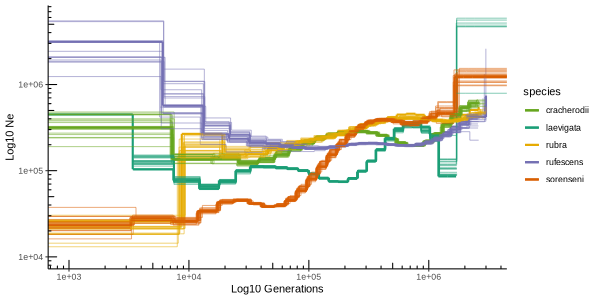

In [3]:
%%R -w 600 -h 300
library(tidyverse)
library(data.table)
library(ggplot2)
library(magrittr)
library(RColorBrewer)

## Set parameters
mu = 8.60e-9
gen = 1

## Read in raw data and process metadata
res = bind_rows(lapply(list.files('demography/msmc/single/', pattern='final.txt',full.names = T), function(PATH){fread(PATH) %>% mutate(path = basename(PATH))}))
res %<>% mutate(species = gsub('_.*','',path), 
                rep = gsub('.final.txt','',path) %>% gsub('^.*_','',.),
                source = ifelse(rep == 'OG','original','bootstrap'))


## Convert intervals to real time and size to Ne
res %<>% 
    ##
    mutate(left_time_boundary = left_time_boundary/mu*gen,
           right_time_boundary = right_time_boundary/mu*gen,
           size = (1/lambda)/(2*mu)) %>%
    ##
    group_by(species, rep) %>%
    mutate(lagsize = lag(size), order_by = path) %>%
    ungroup

## Get confidence intervals
res_summary = 
res %>%
    group_by(species, time_index) %>%
    summarize(mn_left_time_boundary = mean(left_time_boundary), 
              mn_right_time_boundary = mean(right_time_boundary),
              mn_size = mean(size),
              sd_size = sd(size),
              lower_ci = mn_size - qt(0.975, df = n() - 1) * sd_size / sqrt(n()),
              upper_ci = mn_size + qt(0.975, df = n() - 1) * sd_size / sqrt(n())) %>%
    ungroup


## Exploratory plot

cols = brewer.pal(6,"Dark2")
names(cols) = c('laevigata','sorenseni','rufescens','asinina','cracherodii','rubra')

library(wesanderson)
#ogcolor = wes_palette('Moonrise1')[4]
p = ggplot() +
    ##
    geom_segment(data = res %>% filter(source == 'original'), aes(x = left_time_boundary, xend = left_time_boundary, y = size, yend = lagsize, color = species), size = 1) +
    geom_segment(data = res %>% filter(source == 'original'), aes(x = left_time_boundary, xend = right_time_boundary, y = size, yend = size, color = species), size = 1) +
    ##
    geom_segment(data = res %>% filter(source == 'bootstrap'), aes(x = left_time_boundary, xend = left_time_boundary, y = size, yend = lagsize, color = species, group = rep), size = 0.5, alpha = 0.5) +
    geom_segment(data = res %>% filter(source == 'bootstrap'), aes(x = left_time_boundary, xend = right_time_boundary, y = size, yend = size, color = species, group = rep), size = 0.5, alpha = 0.5) +
    #geom_rect(data = res_summary,aes(xmin = mn_left_time_boundary, xmax = mn_right_time_boundary, ymin = lower_ci, ymax = upper_ci, fill = species), alpha = 0.5) +
    ##
    scale_color_manual(values = cols) +
    scale_x_log10(limits = c(1e3,3e6)) +
    scale_y_log10(limits = c(1e4,6e6)) +
    xlab("Log10 Generations") + 
    ylab("Log10 Ne") +
    annotation_logticks() +
    #ylim(c(1,1e6)) + 
    theme_classic() 
    #theme(panel.grid.major.y = element_line(size = 1), panel.grid.minor.y = element_line(size = 1))

print(p)

#ggsave('./mutation_figs/msmc_plot.pdf', width = 6, height = 3)


In [101]:
%%R
res_summary = 
res %>%
    group_by(species, time_index) %>%
    summarize(mn_left_time_boundary = mean(left_time_boundary), 
              mn_right_time_boundary = mean(right_time_boundary),
              mn_size = mean(size),
              sd_size = sd(size),
              lower_ci = mn_size - qt(0.975, df = n() - 1) * sd_size / sqrt(n()),
              upper_ci = mn_size + qt(0.975, df = n() - 1) * sd_size / sqrt(n())) %>%
    ungroup

`summarise()` has grouped output by 'species'. You can override using the
`.groups` argument.


In [117]:
%%R
res %>% 
    filter(left_time_boundary >= 1e4, left_time_boundary <= 1e6) %>% 
    dplyr::select(left_time_boundary,sample,size) %>% 
    group_by(sample) %>%
    mutate(gens = lead(left_time_boundary) - left_time_boundary) %>%
    mutate(harm = (1/size)*gens) %>%
    summarize(total_gens = sum(gens,na.rm =T),denom = sum(harm,na.rm=T)) %>%
    ungroup %>%
    mutate(harmonic_mean = total_gens/denom)

# A tibble: 12 × 4
   sample        total_gens denom harmonic_mean
   <chr>              <dbl> <dbl>         <dbl>
 1 BML309           941688.  4.05       232375.
 2 BML397           895865.  4.02       223011.
 3 FG29             961397.  4.07       236253.
 4 FG30             958515.  4.05       236506.
 5 FG33             955054.  4.07       234609.
 6 Green312         895342.  4.00       223750.
 7 NorbertW740      947894.  3.82       248357.
 8 NorbertW853      848900.  3.89       218279.
 9 ToothlessL824    892070.  4.02       221967.
10 ToothlessL960    923267.  4.02       229544.
11 Y119             928378.  4.10       226683.
12 Y121             893471.  4.26       209666.
